# WHAT ABOUT BOARD GAMES?
###### {Matteo Tarenzi}

<div>
<img src="Images_github/Intro.jpg" width="500" align="center"/> 
</div>

When reviewing or commenting a game, the players tend to focus on certain aspects. The project's goal is to comprehend the use of some of the main features.
In particular, the final objective is to obtain the player base sentiment and the opinion associated with this defined set of features:

LUCK, DOWNTIME, BOOKKEEPING, INTERACTION, BASH-the-LEADER and  COMPLEXITY/COMPLICATEDNEES.

For each aspect, the project will determine the polarization of that feature, and if possible, draw a general opinion that can be used to understand how the players experience them.

In [2]:
# Import various packages for the project
%run Loading/Packages

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')  

In [4]:
# Initialize the sentiment intensity analyzers

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from textblob import TextBlob

In [5]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# FIRST PART:________Obtain games data from BGG API 

Most of this part can be found in the 'BGG_mining' notebook

In [6]:
# Reading
with open('Loading/BGG.json','r') as file:
    BGG=json.load(file)

In [7]:
#Give a lookup at the collection of games 
titles=list(BGG.keys())
BGG[titles[0]]

{'name': 'Die Macher',
 'year_publ': 1986,
 'rating': 7.59346,
 'complexity': 4.3105,
 'categories': ['Economic', 'Negotiation', 'Political'],
 'mechanics': ['Alliances',
  'Area Majority / Influence',
  'Auction/Bidding',
  'Dice Rolling',
  'Hand Management',
  'Simultaneous Action Selection'],
 'min_players': 3.0,
 'max_players': 5.0,
 'min_lenght': 240.0,
 'max_lenght': 240.0,
 'age': 14.0,
 'comments': [["Die Macher is one of the very few long games that I'd like to play on any given opportunity, and I was hugely impressed by its design since my first play. It's long, but it's complex, not complicated: there are different rule systems mixed together to portray different aspects of your political campaign, but each of them is simple to understand and to manipulate during the game. \nMastering the whole system takes time, of course, but you'll find yourself grasping its main dynamics much sooner than you'd expect, probably just after you've gone through the first round of play. So, 

## Retrieve comments, reviews and categories

In [8]:
comments, stars, categories =[],[],[] 
for title in titles:
    for i,comment in enumerate(BGG[title]['comments']):
        try:
            if comment[1]!='N/A':
                comments.append(comment[0])
                stars.append(float(comment[1]))
                categories.append(BGG[title]['categories'])

        except Exception as e:
            print(f"Error processing element {title}: {i}")
            continue
            
len(comments)

343798

# SECOND PART:_______Aspect mining & Words embedding

We are mining the comments to obtain aspects and opinions.
At the same time we are storing the lemmatized words to use them for words embeddings.

In [550]:
from Aspect_mining import explore, noun_mapping, search_adjectives, verb_adjectives, comp_adjectives, clean_dict

In [ ]:
lemmatizer = WordNetLemmatizer()

emb_data=[] #For the data embedding 
stats_data = [] #For the aspects

runs = list(enumerate(comments))
for i, doc in tqdm(runs):
    try:
        comm=nlp(doc)
        cats = categories[i]

        asp_map,sents=noun_mapping(comm)
        asp_dict=search_adjectives(asp_map,a_dict=None)
        asp_dict=verb_adjectives(comm,asp_dict,be_only=True)         # The sintax parsing functions
        asp_dict=comp_adjectives(asp_dict)
        asp_dict,sents=clean_dict(asp_dict,sents)

        
        for a,(aspect, sentiment) in enumerate(asp_dict.items()):
                
            if len(aspect)==1:
                aspect = str(aspect[0])
            elif len(aspect)==2:
                aspect = str(aspect[1]) + ' ' + str(aspect[0])

            for adj in sentiment:
                for cat in cats:

                    stats_data.append({
                        'doc': i,
                        'stars': stars[i], 
                        'category': cat,
                        'adj': lemmatizer.lemmatize(str(adj).lower(),pos='a'),
                        'noun': lemmatizer.lemmatize(aspect.lower()),
                        'sentence': sents[a]
                    })
    except:
        print(f"Error processing element: {i}")
        continue
        
    # Mining of the words for the embedding 
    words=[]
    for x in comm:
        if x.dep_ != 'punct':
            if x.pos_=='ADJ': 
                lemma=lemmatizer.lemmatize(str(x).lower(),pos='a')     # Use a different lemmatizer if ADJ
            else:
                lemma=lemmatizer.lemmatize(str(x).lower())
            words.append(lemma)
    emb_data.append(words)
                
S = pd.DataFrame(stats_data)

 

In [ ]:
# Save the dataframe
S.to_csv('Loading/S.csv', index=False)

In [10]:
## This piece of code jump over the aspect extraction and lemmatization that could requires some time

#S = pd.read_csv('Loading/S.csv')

,doc,stars,category,adj,noun,sentence
0,0,9.0,Economic,very few,game,Die Macher is one of the very few long games t...
1,0,9.0,Negotiation,very few,game,Die Macher is one of the very few long games t...
2,0,9.0,Political,very few,game,Die Macher is one of the very few long games t...
3,0,9.0,Economic,long,game,Die Macher is one of the very few long games t...
4,0,9.0,Negotiation,long,game,Die Macher is one of the very few long games t...


In [ ]:
S.head()


## Words embeddings

Comments store in the previous code are here utilized to run words embedding. The embeddings will be use in the fourth phase of the project to provide some contextual information and possible synonyms regarding the aspects of interest.

In [ ]:
## Adjust the terminology for the embeddings

emb_ft=[' '.join(comment) for comment in emb_data]

emb_ft = [comment.replace('analysis paralysis','analysis_paralysis') for comment in emb_ft]
emb_ft = [comment.replace('ap','analysis_paralysis') for comment in emb_ft]

emb_ft = [comment.replace('luck factor','luck_factor') for comment in emb_ft]

emb_ft= [comment.replace('book keeping','bookkeeping') for comment in emb_ft]

emb_ft = [comment.replace('king making','king_making') for comment in emb_ft]
emb_ft = [comment.replace('kingmaking','king_making') for comment in emb_ft]


emb_ft = [comment.replace('bash','bash_the_leader') if 'leader' in comment or 'Leader' in comment
                     else comment for comment in emb_ft]

emb_ft =[[word for word in comment.split()] for comment in emb_ft]

In [ ]:
emb_ft[0][:10]

In [ ]:
wv_len= 100

R0 = gensim.models.Word2Vec(sentences=emb_ft, epochs=25, window=6, vector_size=wv_len)

In [ ]:
R0.save("Loading/word2vec_model.model")

In [11]:
#Again this code will save some time if you plan to not run the training of words embedding 

#R0=Word2Vec.load("Loading/word2vec_model.model")

In [ ]:
# Test it

R0.wv.most_similar(positive=['bash_the_leader'],negative=[])

# Filtering the aspects 

### ADJ-NOUN Relevance

In [12]:
## Adjust the terminology for the aspects-opinions

S['noun'] = S['noun'].apply(lambda x: 'analysis_paralysis' if x=='ap' else x)
S['noun'] = S['noun'].apply(lambda x: 'analysis_paralysis' if x=='analysis paralysis' else x)

S['noun'] = S['noun'].apply(lambda x: 'luck_factor' if x=='luck factor' else x)
S['noun'] = S['noun'].apply(lambda x: 'luck_factor' if x=='luck' else x)


S['noun'] = S['noun'].apply(lambda x: 'bookkeeping' if x=='bookeeping' else x)

S['noun'] = S['noun'].apply(lambda x: 'king_making' if x=='king making' else x)
S['noun'] = S['noun'].apply(lambda x: 'king_making' if x=='kingmaking' else x)


condition = ((S['noun'] == 'bash') & S['sentence'].apply(lambda x: 'leader' in x or 'Leader' in x))
S.loc[condition, 'noun'] = 'bash_the_leader'


In [13]:
## Filtering those aspects that are punctuation

import string
punctuation = list(string.punctuation)

S = S[~S['noun'].isin(punctuation)]
S = S[~S['adj'].isin(punctuation)]


## Compute the PMI for NOUN-ADJ

We'll use PMI for NOUN-ADJECTIVE pairs to retain those aspects that are more important.

In [14]:
# Group to set aside category
Sdoc = S.groupby(['adj','noun','doc']).first().reset_index()[['adj','noun','doc','stars']]

In [15]:
Sdoc.head()

,adj,noun,doc,stars
0,"""casino",complex,138163,6.0
1,"""susie",artwork,192015,6.0
2,* balance,role,341325,7.0
3,* map,bridghead,279566,9.0
4,* repackaging,game,96687,8.1


In [16]:
min_freq=5
pmi_an = Sdoc.groupby(['noun','adj']).agg({'stars': ['mean', 'count']}).reset_index()
pmi_an.columns = ['noun','adj', 'mean_stars', 'doc_count']
pmi_an = pmi_an[pmi_an['doc_count']>= min_freq]

pmi_an.reset_index(inplace=True,drop=True)

In [17]:

total_docs = pmi_an['doc_count'].sum()
adj_counts = pmi_an.groupby('adj')['doc_count'].sum().to_dict()
noun_counts = pmi_an.groupby('noun')['doc_count'].sum().to_dict()
adj_noun_counts = pmi_an.groupby(['adj', 'noun'])['doc_count'].sum().to_dict()



In [18]:
# Import functions for PMI and sentiment evaluation of synsets
import Functions
from Functions import compute_pmi, sentiwn_score

In [19]:
import math

pmi_an['pmi']=None
pmi_an['Synset_pol']= None


for i,noun in enumerate(pmi_an.noun.values):
    pmi_an.loc[i,'pmi']= compute_pmi(pmi_an.loc[i,'adj'],pmi_an.loc[i,'noun'], 
                                   adj_noun_counts[(pmi_an.loc[i,'adj'],pmi_an.loc[i,'noun'])], 
                                   adj_counts, noun_counts, total_docs)
    
    pmi_an.loc[i,'Synset_pol']= np.mean([sentiwn_score(item) for item in pmi_an.loc[i,'adj'].split()])
    
    
pmi_an= pmi_an.loc[(pmi_an['pmi'] > 1)]  # Retain the best pairs


pmi_an.set_index(['noun','adj'], inplace=True)


###  Add to the original Dataframe these features 

We add the PMI and sentiment to the original dataframe.

In [20]:
cats,adjs, nouns = S.category.values, S.adj.values, S.noun.values

S['feature']= S.apply(lambda row: (row['noun'], row['adj']), axis=1)

S['count'] = [pmi_an.loc[(nouns[i],adjs[i])].doc_count if (
  nouns[i],adjs[i]) in pmi_an.index else np.nan for i in range(S.shape[0])]

S['pmi_an'] = [pmi_an.loc[(nouns[i],adjs[i])].pmi if (
  nouns[i],adjs[i]) in pmi_an.index else np.nan for i in range(S.shape[0])]

S['Synset_pol'] = [pmi_an.loc[(nouns[i],adjs[i])].Synset_pol if (
  nouns[i],adjs[i]) in pmi_an.index else np.nan for i in range(S.shape[0])]

In [21]:
# The general dataframe with aspects 

Sn = S.dropna(inplace=False).copy()

# Gather sentiment score from the sentence
sentiment_scores = Sn['sentence'].apply(lambda sent: sid.polarity_scores(sent))

Sn[['Sent_neg', 'Sent_neu', 'Sent_pos']] = sentiment_scores.apply(
    lambda x: pd.Series([x['neg'], x['neu'], x['pos']]))

Sn=Sn[['doc','category','noun','adj','count','pmi_an','Synset_pol','Sent_neg', 'Sent_neu', 'Sent_pos','stars','sentence']]

Sn.head()


,doc,category,noun,adj,count,pmi_an,Synset_pol,Sent_neg,Sent_neu,Sent_pos,stars,sentence
6,0,Economic,play,first,1136.0,2.219646,0.054688,0.094,0.58,0.326,9.0,Die Macher is one of the very few long games t...
7,0,Negotiation,play,first,1136.0,2.219646,0.054688,0.094,0.58,0.326,9.0,Die Macher is one of the very few long games t...
8,0,Political,play,first,1136.0,2.219646,0.054688,0.094,0.58,0.326,9.0,Die Macher is one of the very few long games t...
12,0,Economic,aspect,different,39.0,1.552362,0.050000,0.000,1.00,0.000,9.0,"It's long, but it's complex, not complicated: ..."
13,0,Negotiation,aspect,different,39.0,1.552362,0.050000,0.000,1.00,0.000,9.0,"It's long, but it's complex, not complicated: ..."


# THIRD PART_____Comments sentiment prediction

We want to create a supervized model that predicts the score of a comment using the aspects that are present in that comment. The model will be trained and tested for classification  with a special focus on explanability rather than performances.

In [22]:
S_pred=Sn.groupby(['doc','noun','adj']).first().reset_index()[['doc','noun','adj','count','pmi_an','Synset_pol','Sent_neg', 'Sent_neu', 'Sent_pos','stars','sentence']]

S_pred.head()



,doc,noun,adj,count,pmi_an,Synset_pol,Sent_neg,Sent_neu,Sent_pos,stars,sentence
0,0,aspect,different,39.0,1.552362,0.050000,0.000,1.000,0.000,9.0,"It's long, but it's complex, not complicated: ..."
1,0,play,first,1136.0,2.219646,0.054688,0.094,0.580,0.326,9.0,Die Macher is one of the very few long games t...
2,0,round,first,255.0,2.886992,0.054688,0.000,0.839,0.161,9.0,"Mastering the whole system takes time, of cour..."
3,0,system,streamlined,15.0,3.412305,0.083333,0.000,0.762,0.238,9.0,"The system is streamlined and functional, the ..."
4,1,implementation,poor,5.0,4.161995,-0.410714,0.159,0.841,0.000,6.0,And the Valley Games implementation is really ...


In [23]:
features = list(pmi_an.index.values)

print(S_pred.shape)
print(len(features))
print(len(R0.wv[0]))

(374111, 11)
16883
100


# Classification with Born Classifier

We'll use the Born Classifier as supervised algorithm, mostly for his high explanability.

In [24]:
#Scale

scaler=MinMaxScaler()
scaled_pmi= scaler.fit_transform(S_pred[['pmi_an','Synset_pol']].values)

sent= S_pred.Sent_neg.values - S_pred.Sent_neg.values
scaled_sent= scaler.fit_transform(sent.reshape(-1,1))



In [25]:
## Cut out some documents because of memory limitations

S_pred_ft= S_pred[:250000]


#### Data Matrix

Here we set the data in a suitable format for the classifier.
A sparse matrix where each row row represent a comment, and each column(feature) represent a distinct noun-adj pair. The values are populated with a combination of pmi and sentence sentiment.

At the same time, the categorical output variable is obtained using the score given by the user. 

In [635]:

X= np.zeros((max(S_pred_ft.doc.values)+1,len(features)))
y=[]

nouns= S_pred_ft.noun.values
adjs= S_pred_ft.adj.values

for i,doc in enumerate(S_pred_ft.doc.values):
    noun=nouns[i]
    adj=adjs[i]
    
    X[doc,features.index((noun,adj))] = (scaled_pmi[i][0])+0.01

    
for doc in set(S_pred_ft.doc.values):   
    y.append(np.mean(S_pred_ft[S_pred_ft['doc']==doc].stars))

X = X[np.any(X != 0, axis=1)]

Y=[]

for star in y:
    if star >= 7:
        opinion='Positive'
    elif star >=5.5 and star < 7:
        opinion='Neutral'
    elif star < 5.5:
        opinion='Negative'
        
    Y.append(opinion)
    
print(X.shape)
print(len(Y))

(125682, 16883)
125682


### The Born Classifier training and testing


In [636]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [637]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,stratify=Y, random_state=123)

In [638]:
from collections import Counter

Counter(Y_train)

Counter({'Neutral': 25819, 'Negative': 26357, 'Positive': 48369})

In [639]:
from bornrule import BornClassifier

In [640]:
bc = BornClassifier()
bc.fit(X_train,Y_train)
bc_pred = bc.predict(X_test)

In [641]:
labels=bc.classes_
labels

array(['Negative', 'Neutral', 'Positive'], dtype='<U8')

In [642]:
print(classification_report(Y_test, bc_pred, zero_division=0,labels=labels))

              precision    recall  f1-score   support

    Negative       0.42      0.51      0.46      6589
     Neutral       0.31      0.34      0.32      6455
    Positive       0.64      0.54      0.58     12093

    accuracy                           0.48     25137
   macro avg       0.46      0.46      0.46     25137
weighted avg       0.50      0.48      0.49     25137



## Explanation of the results

### Global

In [48]:
E = pd.DataFrame(bc.explain(), index=features, columns=labels)
E=E[['Positive','Neutral','Negative']]
E['noun']=[noun for noun,adj in features]
E['adj']=[adj for noun,adj in features]



In [610]:
# Filtering out 'game' to obtain more information about other aspects

E[E['noun']!='game'].sort_values('Positive', ascending=False).head(10)

,Positive,Neutral,Negative,noun,adj
"(expansion, great)",0.024125,0.007345,0.006736,expansion,great
"(classic, true)",0.021213,0.006398,0.001774,classic,true
"(player game, great)",0.019393,0.009452,0.002360,player game,great
"(wargame, favorite)",0.019366,0.000000,0.000000,wargame,favorite
"(fun, great)",0.018311,0.012326,0.007687,fun,great
"(downside, only)",0.016149,0.007808,0.000000,downside,only
"(ccg, favorite)",0.015936,0.006787,0.000000,ccg,favorite
"(as, bad)",0.015838,0.003081,0.000000,as,bad
"(auction game, great)",0.015581,0.004629,0.000000,auction game,great
"(racing game, best)",0.015346,0.005657,0.002504,racing game,best


In [614]:
E[E['noun']!='game'].sort_values('Negative', ascending=False).head(15)

,Positive,Neutral,Negative,noun,adj
"(idea, interesting)",0.005795,0.012516,0.020425,idea,interesting
"(disappointment, big)",0.001308,0.004811,0.019318,disappointment,big
"(gameplay, boring)",0.000000,0.006206,0.016243,gameplay,boring
"(idea, not bad)",0.000000,0.000000,0.016212,idea,not bad
"(control, very little)",0.002797,0.004193,0.016015,control,very little
"(trivia game, bad)",0.000000,0.000000,0.015088,trivia game,bad
"(minute, first)",0.004286,0.003911,0.014396,minute,first
"(execution, poor)",0.002069,0.000000,0.014388,execution,poor
"(fun, not much)",0.003252,0.007729,0.014327,fun,not much
"(experience, bad)",0.003927,0.004013,0.014313,experience,bad


### Local

In [51]:
E_local = pd.DataFrame(bc.explain(X_test[1].reshape(1, -1)), index=features, columns=labels)
E_local=E_local[['Positive','Neutral','Negative']]

In [52]:
E_local.sort_values('Positive', ascending=False).head(5)

,Positive,Neutral,Negative
"(expansion, good)",0.003205,0.002621,0.001728
"(interaction, more)",0.000383,0.000296,0.000444
"(.5, extra)",0.000000,0.000000,0.000000
"(player, soviet)",0.000000,0.000000,0.000000
"(player, sweet)",0.000000,0.000000,0.000000


# FOURTH PART:______ Board Game apects insights
 
We'll use the word embeddings and the previous results to obtain information and possibly comprehend each of the aspects that are the object of the study. 

In [416]:
import importlib
import Functions
importlib.reload(Functions)

<module 'Functions' from '/Users/matteo/Documents/Projects/Text_Mining/Functions.py'>

In [417]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

from Functions import get_df, get_born, get_info, mean_int, get_cloud

# N°1: Luck

In [418]:
R0.wv.most_similar(positive=['luck'])

[('randomness', 0.826627790927887),
 ('rng', 0.6569284796714783),
 ('luck_factor', 0.6432054042816162),
 ('guesswork', 0.6101874709129333),
 ('random', 0.6016546487808228),
 ('skill', 0.5829452872276306),
 ('chaos', 0.5804243087768555),
 ('screwage', 0.568000078201294),
 ('strategy', 0.5677871108055115),
 ('bluffing', 0.5466306805610657)]

In [419]:
luck_similarity_nouns=['luck_factor','chaos','randomness']
luck_similarity_adjs=['lucky','unlucky','chaotic','randomic']



#### Most important factors for a positive or negative review

In [420]:
E_luck= get_born(E,luck_similarity_nouns)
E_luck.sort_values('Positive', ascending=False).head(3)

,Positive,Neutral,Negative
"(luck_factor, good combination)",0.007984,0.000000,0.0
"(randomness, just enough)",0.007365,0.001973,0.0
"(luck_factor, good blend)",0.006820,0.000000,0.0


In [421]:
E_luck.sort_values('Negative', ascending=False).head(3)

,Positive,Neutral,Negative
"(luck_factor, pure)",0.003610,0.006909,0.013498
"(luck_factor, too much)",0.004257,0.007732,0.010886
"(luck_factor, blind)",0.001973,0.000000,0.010682


## Summary Dataframe

In [422]:
Sn_luck= get_df(Sn,luck_similarity_nouns,luck_similarity_adjs,[])

Final_luck_nouns=get_info(luck_similarity_nouns,[],Sn_luck,E)

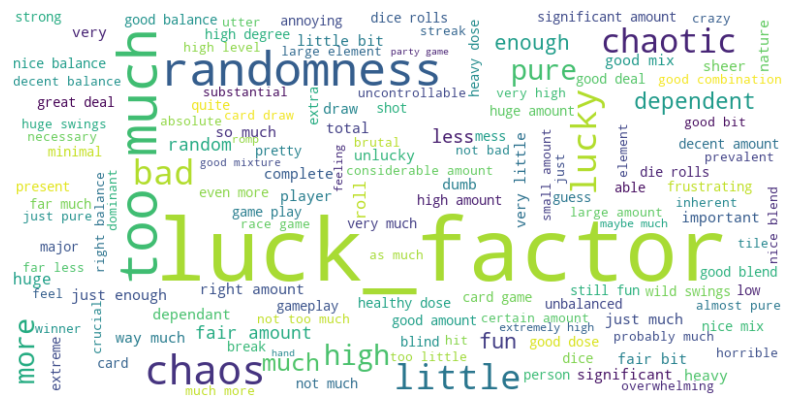

In [423]:
get_cloud(Sn_luck)

In [424]:
chaos_low=Final_luck_nouns[Final_luck_nouns['Object']=='chaos'].sort_values(['Mean_Stars'])[:5]
chaos_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
109,chaos,way much,6.0,0.0673,0.3882,0.5634,0.0483,4.833
104,chaos,total,23.0,0.0000,0.3753,0.4796,0.1450,4.976
113,chaos,just much,9.0,0.2188,0.2877,0.6421,0.0702,5.000
111,chaos,much,12.0,0.1250,0.2807,0.6459,0.0734,5.185
118,chaos,pure,19.0,0.1607,0.3002,0.5719,0.1277,5.291


In [426]:
chaos_top=Final_luck_nouns[Final_luck_nouns['Object']=='chaos'].sort_values(['Mean_Stars'],ascending=False)[:5]
chaos_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
114,chaos,enough,7.0,0.0833,0.1707,0.6135,0.2159,6.941
108,chaos,less,10.0,-0.1458,0.1961,0.6266,0.1770,6.823
116,chaos,sheer,6.0,-0.0625,0.1692,0.6786,0.1524,6.559
110,chaos,more,92.0,0.0000,0.2924,0.5992,0.1084,6.476
112,chaos,right amount,7.0,0.0600,0.2497,0.7152,0.0352,6.383


In [428]:
luck_low=Final_luck_nouns[Final_luck_nouns['Object']=='luck_factor'].sort_values(['Mean_Stars'])[:5]
luck_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
36,luck_factor,uncontrollable,6.0,-0.4688,0.2163,0.5988,0.1849,3.786
61,luck_factor,complete,12.0,0.3000,0.0190,0.6388,0.3423,3.847
88,luck_factor,total,12.0,0.0000,0.0187,0.6401,0.3412,3.917
1,luck_factor,far much,14.0,0.0875,0.0481,0.6653,0.2868,4.223
11,luck_factor,brutal,6.0,-0.4375,0.2036,0.6706,0.1258,4.250


In [430]:
luck_top=Final_luck_nouns[Final_luck_nouns['Object']=='luck_factor'].sort_values(['Mean_Stars'],ascending=False)[:5]
luck_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
59,luck_factor,nice blend,6.0,0.2500,0.0000,0.4511,0.5489,8.286
45,luck_factor,nice balance,8.0,0.2396,0.0000,0.4865,0.5135,8.232
100,luck_factor,good combination,7.0,0.2824,0.0000,0.5048,0.4952,8.053
55,luck_factor,just enough,18.0,0.1979,0.0318,0.7064,0.2617,7.991
53,luck_factor,good mix,33.0,0.2824,0.0183,0.4864,0.4953,7.847


In [432]:
rnd_low=Final_luck_nouns[Final_luck_nouns['Object']=='randomness'].sort_values(['Mean_Stars'])[:5]
rnd_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
146,randomness,pure,6.0,0.1607,0.0355,0.8243,0.1402,3.692
127,randomness,even more,9.0,0.0134,0.0528,0.8918,0.0554,3.796
131,randomness,way much,6.0,0.0673,0.0407,0.8701,0.0892,3.810
137,randomness,just much,14.0,0.2188,0.0232,0.8657,0.1111,4.100
122,randomness,complete,17.0,0.3000,0.1354,0.7555,0.1088,4.147


In [434]:
rnd_top=Final_luck_nouns[Final_luck_nouns['Object']=='randomness'].sort_values(['Mean_Stars'],ascending=False)[:5]
rnd_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
140,randomness,very little,5.0,0.0281,0.0238,0.8848,0.0915,7.688
144,randomness,just enough,22.0,0.1979,0.0271,0.8143,0.1586,7.599
147,randomness,little,32.0,-0.2250,0.0378,0.8023,0.1599,7.443
124,randomness,healthy dose,5.0,0.2979,0.0102,0.7589,0.2309,6.938
138,randomness,little bit,6.0,-0.1500,0.0304,0.8878,0.0818,6.833


### What do luck refers to ? 

In [436]:
Final_luck_adjs=get_info([],luck_similarity_adjs[:1],Sn_luck,E)

luck_count=Final_luck_adjs.sort_values(['Count'],ascending=False)[:5]
luck_count

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
16,roll,lucky,56.0,0.7917,0.0687,0.7145,0.2168,6.114
0,draw,lucky,35.0,0.7917,0.0651,0.6817,0.2532,6.138
4,player,lucky,30.0,0.7917,0.0918,0.6695,0.2388,5.460
8,card,lucky,23.0,0.7917,0.0520,0.7274,0.2205,5.000
1,die rolls,lucky,16.0,0.7917,0.2356,0.5796,0.1848,5.212


In [438]:
ASPECTS=[]


ASPECTS.append({
    'OBJECT': 'LUCK',
    'Similar': luck_similarity_nouns,
    'Synset_pol': round(np.average(Final_luck_nouns.Synset_pol.values,weights=Final_luck_nouns.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_luck_nouns.Sentence_neg.values,weights=Final_luck_nouns.Count.values),2),
        'neu':round(np.average(Final_luck_nouns.Sentence_neu.values,weights=Final_luck_nouns.Count.values),2),
        'pos':round(np.average(Final_luck_nouns.Sentence_pos.values,weights=Final_luck_nouns.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_luck_nouns.Mean_Stars.values,weights=Final_luck_nouns.Count.values),2)
})


[{'OBJECT': 'LUCK',
  'Similar': ['luck_factor', 'chaos', 'randomness'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.08, 'neu': 0.65, 'pos': 0.27},
  'Mean_Stars': 5.9}]

# N°1_BIS: Strategy

We will also study strategy, since from the embeddings it looks like these two are similar but quite contradictory if we think. 

In [439]:
R0.wv.most_similar(positive=['strategy'])

[('skill', 0.7178090810775757),
 ('tactic', 0.7156224250793457),
 ('stategy', 0.6859423518180847),
 ('depth', 0.6402407884597778),
 ('subtlety', 0.6332187652587891),
 ('finesse', 0.6132321357727051),
 ('guesswork', 0.6082715392112732),
 ('strategic', 0.5751734972000122),
 ('luck', 0.5677871108055115),
 ('randomness', 0.5657109618186951)]

In [440]:
strat_similarity_nouns=['strategy','tactic','skill']
strat_similarity_adjs=['strategic','tactical','skilled']

## Summary Dataframe 

In [441]:
Sn_strat= get_df(Sn,strat_similarity_nouns,strat_similarity_adjs,[])

Final_strat_nouns=get_info(strat_similarity_nouns,[],Sn_strat,E)


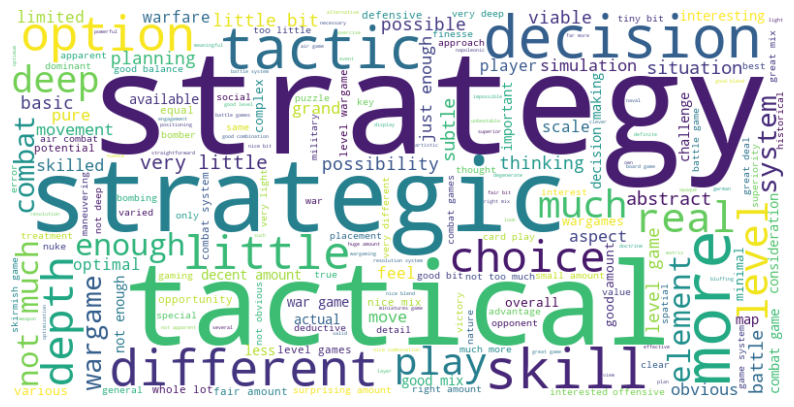

In [442]:
get_cloud(Sn_strat)

In [443]:
Final_strat_nouns.sort_values(['Object','Mean_Stars'])

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
158,skill,only,13.0,-0.0278,0.0440,0.8815,0.0745,3.945
167,skill,particular,5.0,0.0417,0.1231,0.7520,0.1249,4.667
163,skill,less,7.0,-0.1458,0.0760,0.7575,0.1665,5.048
178,skill,very little,16.0,0.0281,0.0487,0.7678,0.1835,5.216
160,skill,unequal,5.0,-0.3750,0.2424,0.6602,0.0975,5.409
...,...,...,...,...,...,...,...,...
148,tactic,defensive,10.0,0.0000,0.0932,0.6865,0.2203,7.893
122,tactic,realistic,5.0,-0.0833,0.0060,0.9570,0.0370,8.000
127,tactic,offensive,6.0,-0.4758,0.1710,0.6406,0.1882,8.029
151,tactic,deep,7.0,0.0595,0.0228,0.8035,0.1737,8.135


### What do strategy refers to ? 

In [444]:
Final_strat_adjs=get_info([],strat_similarity_adjs,Sn_strat,E)

Final_strat_adjs.sort_values(['Count'],ascending=False)[:5]

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
114,decision,tactical,261.0,0.0000,0.0487,0.7682,0.1830,6.860
75,play,tactical,186.0,0.0000,0.0429,0.6363,0.3209,6.952
29,option,strategic,186.0,0.0625,0.0565,0.7734,0.1701,6.924
9,depth,strategic,172.0,0.0625,0.0331,0.7939,0.1730,6.939
23,decision,strategic,145.0,0.0625,0.0596,0.7927,0.1476,6.896


## Summary

In [445]:
{
    'OBJECT': 'STRATEGY',
    'Similar': strat_similarity_nouns,
    'Synset_pol': round(np.average(Final_strat_nouns.Synset_pol.values,weights=Final_strat_nouns.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_strat_nouns.Sentence_neg.values,weights=Final_strat_nouns.Count.values),2),
        'neu':round(np.average(Final_strat_nouns.Sentence_neu.values,weights=Final_strat_nouns.Count.values),2),
        'pos':round(np.average(Final_strat_nouns.Sentence_pos.values,weights=Final_strat_nouns.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_strat_nouns.Mean_Stars.values,weights=Final_strat_nouns.Count.values),2)
}


{'OBJECT': 'STRATEGY',
 'Similar': ['strategy', 'tactic', 'skill'],
 'Synset_pol': 0.04,
 'Sentence_pol': {'neg': 0.04, 'neu': 0.78, 'pos': 0.18},
 'Mean_Stars': 6.42}

# N°2 : INTERACTION

In [446]:
R0.wv.most_similar(positive=['interactive'])

[('thematic', 0.6605557799339294),
 ('engaging', 0.6478056311607361),
 ('engrossing', 0.6430256962776184),
 ('thoughtful', 0.642997145652771),
 ('addictive', 0.6287288069725037),
 ('replayable', 0.6157259941101074),
 ('competitive', 0.6134252548217773),
 ('intricate', 0.6121371388435364),
 ('intense', 0.595826268196106),
 ('addicting', 0.5936900973320007)]

In [447]:
int_similarity_nouns=['interaction','interactivity','influence']
int_similarity_adjs=['interactive']

#### Most important factor for a positive or negative review

In [448]:
E_int= get_born(E,int_similarity_nouns)
E_int.sort_values('Positive', ascending=False).head(3)

,Positive,Neutral,Negative
"(interaction, nasty)",0.004861,0.000000,0.000000
"(interaction, human)",0.004861,0.000000,0.000000
"(interaction, direct)",0.003261,0.002552,0.000831


In [449]:
E_int.sort_values('Negative', ascending=False).head(3)

,Positive,Neutral,Negative
"(interaction, real)",0.001678,0.000000,0.007480
"(interaction, only)",0.001810,0.000000,0.006767
"(influence, -limited)",0.001057,0.007519,0.006563


## Summary Dataframe

In [450]:
Sn_int= get_df(Sn,int_similarity_nouns,int_similarity_adjs,[])

Final_int_nouns=get_info(int_similarity_nouns,[],Sn_int,E)

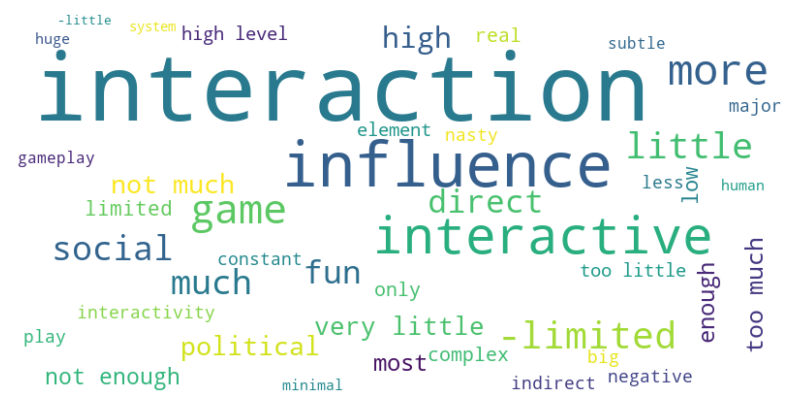

In [451]:
get_cloud(Sn_int)

In [555]:
int_low=Final_int_nouns.sort_values(['Mean_Stars'])[:10]
int_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
34,influence,-little,5.0,0.0000,0.0000,0.6140,0.3860,2.400
38,influence,little,9.0,-0.2250,0.0295,0.8960,0.0745,4.582
0,interaction,only,10.0,-0.0278,0.0757,0.8628,0.0615,4.839
29,influence,much,10.0,0.1250,0.0344,0.9072,0.0584,4.971
4,interaction,real,14.0,0.0096,0.1516,0.7647,0.0836,5.100
21,interaction,not enough,12.0,-0.2708,0.0510,0.8871,0.0618,5.136
28,influence,-limited,42.0,0.0000,0.2201,0.3988,0.3814,5.267
9,interaction,too much,6.0,0.0312,0.0087,0.7538,0.2375,5.269
24,interaction,too little,7.0,-0.1438,0.0197,0.8733,0.1069,5.346
22,interaction,limited,9.0,-0.1477,0.1122,0.8106,0.0772,5.385


In [549]:
int_top=Final_int_nouns.sort_values(['Mean_Stars'],ascending=False)[:10]
int_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
1,interaction,human,5.0,0.0000,0.0846,0.7953,0.1201,8.038
35,influence,major,5.0,0.0481,0.0265,0.8997,0.0738,7.860
18,interaction,direct,35.0,0.0365,0.0509,0.8005,0.1486,7.356
6,interaction,indirect,7.0,-0.3250,0.0393,0.8382,0.1226,7.350
8,interaction,fun,18.0,-0.0312,0.0066,0.6885,0.3049,7.188
10,interaction,less,8.0,-0.1458,0.0494,0.8733,0.0774,7.136
7,interaction,high,21.0,0.0556,0.0628,0.7596,0.1776,7.096
16,interaction,complex,12.0,-0.0250,0.0148,0.7994,0.1859,7.089
2,interaction,high level,10.0,0.0278,0.0336,0.7873,0.1791,7.078
32,influence,huge,5.0,-0.1250,0.0175,0.8170,0.1655,7.038


### What is interaction about ? 

In [456]:
Final_int_adjs=get_info(_,int_similarity_adjs,Sn_int,E)

In [595]:
int_count=Final_int_adjs.sort_values(['Count'],ascending=False)[:10]
int_count

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
5,game,interactive,59.0,0.125,0.0160,0.6918,0.2921,7.217
2,fun,interactive,14.0,0.125,0.0328,0.6280,0.3392,7.128
3,element,interactive,10.0,0.125,0.0903,0.7650,0.1448,7.492
4,play,interactive,8.0,0.125,0.0644,0.6189,0.3169,7.702
0,gameplay,interactive,6.0,0.125,0.0687,0.7131,0.2182,7.514
1,system,interactive,5.0,0.125,0.0000,0.6783,0.3217,7.364


In [459]:
ASPECTS.append({
    'OBJECT': 'INTERACTION',
    'Similar': int_similarity_nouns,
    'Synset_pol': round(np.average(Final_int_nouns.Synset_pol.values,weights=Final_int_nouns.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_int_nouns.Sentence_neg.values,weights=Final_int_nouns.Count.values),2),
        'neu':round(np.average(Final_int_nouns.Sentence_neu.values,weights=Final_int_nouns.Count.values),2),
        'pos':round(np.average(Final_int_nouns.Sentence_pos.values,weights=Final_int_nouns.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_int_nouns.Mean_Stars.values,weights=Final_int_nouns.Count.values),2)
})


[{'OBJECT': 'LUCK',
  'Similar': ['luck_factor', 'chaos', 'randomness'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.08, 'neu': 0.65, 'pos': 0.27},
  'Mean_Stars': 5.9},
 {'OBJECT': 'INTERACTION',
  'Similar': ['interaction', 'interactivity', 'influence'],
  'Synset_pol': -0.05,
  'Sentence_pol': {'neg': 0.07, 'neu': 0.77, 'pos': 0.16},
  'Mean_Stars': 6.22}]

# N°3: Book-keeping

In [460]:
R0.wv.most_similar(positive=['bookkeeping'])

[('panalysis_paralysiserwork', 0.8024028539657593),
 ('accounting', 0.6984066963195801),
 ('bookeeping', 0.696976900100708),
 ('calculation', 0.6763617992401123),
 ('recordkeeping', 0.674033522605896),
 ('wristage', 0.6410932540893555),
 ('downtime', 0.6195991635322571),
 ('fiddlyness', 0.5982170104980469),
 ('fiddliness', 0.5964791774749756),
 ('upkeep', 0.592934787273407)]

In [461]:
book_similarity=['bookkeeping','paperwork','scorekeeping','accounting']

#### Most important factor for a positive or negative review

In [462]:
E_book= get_born(E,book_similarity)
E_book.sort_values('Positive', ascending=False).head(3)

,Positive,Neutral,Negative
"(paperwork, less)",0.002491,0.0,0.002293
"(bookkeeping, little)",0.002204,0.0,0.001724
"(bookkeeping, more)",0.001724,0.0,0.003075


In [463]:
E_book.sort_values('Negative', ascending=False).head(3)

,Positive,Neutral,Negative
"(paperwork, too much)",0.000000,0.0000,0.013066
"(bookkeeping, too much)",0.000567,0.0042,0.007019
"(bookkeeping, tedious)",0.001437,0.0000,0.006717


## Summary Dataframe

In [464]:
Sn_book= get_df(Sn,book_similarity,[],[])

Final_book=get_info(book_similarity,[],Sn_book,E)

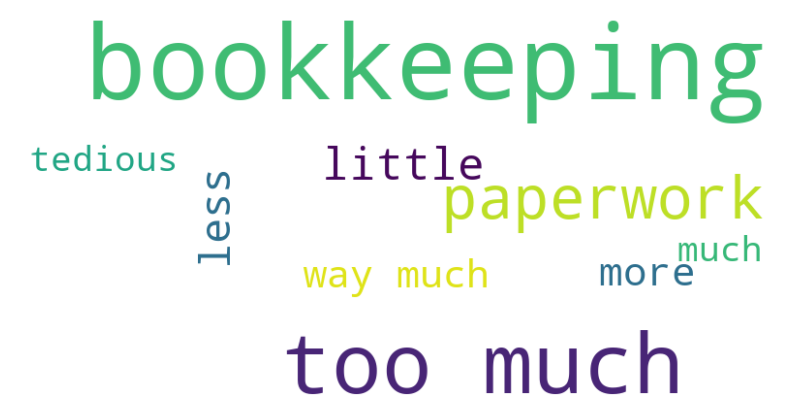

In [465]:
get_cloud(Sn_book)

In [546]:
book=Final_book.sort_values(['Mean_Stars'])
book

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
2,bookkeeping,tedious,6.0,-0.1250,0.0000,0.9336,0.0664,4.062
6,paperwork,too much,7.0,0.0312,0.0690,0.8520,0.0794,4.308
4,bookkeeping,way much,6.0,0.0673,0.0690,0.8195,0.1115,4.350
3,bookkeeping,too much,27.0,0.0312,0.0496,0.8303,0.1201,5.198
0,bookkeeping,much,5.0,0.1250,0.0795,0.8548,0.0658,5.875
7,paperwork,less,5.0,-0.1458,0.0000,0.7969,0.2031,6.125
5,bookkeeping,little,8.0,-0.2250,0.0767,0.7757,0.1477,6.865
1,bookkeeping,more,7.0,0.0000,0.0534,0.8265,0.1203,7.571


### Different categories experience bookkeeping in different ways

We'll do a Kruskal-Wallis test (non-parametric test for the medians) to test if different categories experience it differently.

In [468]:

counter_res = Counter(Sn[Sn['noun'] == 'bookkeeping']['category'].values)

# Sort the result by count in descending order
sorted(counter_res.items(), key=lambda x: x[1], reverse=True)[:5]

[('Wargame', 39),
 ('Science Fiction', 15),
 ('World War II', 10),
 ('Economic', 10),
 ('Negotiation', 8)]

In [536]:

War_stars=list(Sn_book[Sn_book['category']=='Wargame'].stars.values)
Economic_stars=list(Sn_book[Sn_book['category']=='Economic'].stars.values)
Negotiation_stars=list(Sn_book[Sn_book['category']=='Negotiation'].stars.values)
WW2_stars=list(Sn_book[Sn_book['category']=='World War II'].stars.values)
Science_stars=list(Sn_book[Sn_book['category']=='Science Fiction'].stars.values)



h_statistic, p_value = stats.kruskal(War_stars,Economic_stars,Negotiation_stars,WW2_stars,Science_stars)

print(f" The Kruskal-Wallis H Test:  'h_statistic': {round(h_statistic,2)}  'p_value': {p_value}")
print('   ')

print(f"The mean confidence interval for War Games is: {mean_int(War_stars)[1]}-{mean_int(War_stars)[2]}")
print(f"The mean confidence interval for Economic Games is: {mean_int(Economic_stars)[1]}-{mean_int(Economic_stars)[2]}")
print(f"The mean confidence interval Negotiation Games is: {mean_int(Negotiation_stars)[1]}-{mean_int(Negotiation_stars)[2]}")
print(f"The mean confidence interval for WW2 Games is: {mean_int(WW2_stars)[1]}-{mean_int(WW2_stars)[2]}")
print(f"The mean confidence interval Science Fiction Games is: {mean_int(Science_stars)[1]}-{mean_int(Science_stars)[2]}")



 The Kruskal-Wallis H Test:  'h_statistic': 6.06  'p_value': 0.19481343599401008
   
The mean confidence interval for War Games is: 5.237-6.163
The mean confidence interval for Economic Games is: 3.958-5.642
The mean confidence interval Negotiation Games is: 4.438-6.162
The mean confidence interval for WW2 Games is: 5.054-7.346
The mean confidence interval Science Fiction Games is: 5.037-6.363


In [470]:

ASPECTS.append({
    'OBJECT': 'BOOKKEEPING',
    'Similar': book_similarity,
    'Synset_pol': round(np.average(Final_book.Synset_pol.values,weights=Final_book.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_book.Sentence_neg.values,weights=Final_book.Count.values),2),
        'neu':round(np.average(Final_book.Sentence_neu.values,weights=Final_book.Count.values),2),
        'pos':round(np.average(Final_book.Sentence_pos.values,weights=Final_book.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_book.Mean_Stars.values,weights=Final_book.Count.values),2)
})


[{'OBJECT': 'LUCK',
  'Similar': ['luck_factor', 'chaos', 'randomness'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.08, 'neu': 0.65, 'pos': 0.27},
  'Mean_Stars': 5.9},
 {'OBJECT': 'INTERACTION',
  'Similar': ['interaction', 'interactivity', 'influence'],
  'Synset_pol': -0.05,
  'Sentence_pol': {'neg': 0.07, 'neu': 0.77, 'pos': 0.16},
  'Mean_Stars': 6.22},
 {'OBJECT': 'BOOKKEEPING',
  'Similar': ['bookkeeping', 'paperwork', 'scorekeeping', 'accounting'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.05, 'neu': 0.83, 'pos': 0.12},
  'Mean_Stars': 5.48}]

# N°4: Downtime

In [471]:
R0.wv.most_similar(positive=['downtime'])

[('analysis_paralysis', 0.6920583844184875),
 ('interaction', 0.659511387348175),
 ('randomness', 0.6456606388092041),
 ('bookkeeping', 0.6195991635322571),
 ('screwage', 0.612591028213501),
 ('king_making', 0.5965080857276917),
 ('interactivity', 0.5697910189628601),
 ('length', 0.5697890520095825),
 ('chaos', 0.5526027083396912),
 ('luck_factor', 0.5393149256706238)]

In [472]:
down_similarity=['downtime','analysis_paralysis']

#### Most important factor for a positive or negative review

In [473]:
E_down= get_born(E,down_similarity)
E_down.sort_values('Positive', ascending=False).head(3)

,Positive,Neutral,Negative
"(downtime, very little)",0.007800,0.003056,0.0
"(downtime, not much)",0.003571,0.001881,0.0
"(analysis_paralysis, too much)",0.002652,0.002033,0.0


In [474]:
E_down.sort_values('Negative', ascending=False).head(3)

,Positive,Neutral,Negative
"(downtime, massive)",0.000000,0.000000,0.006160
"(downtime, huge)",0.001372,0.000000,0.004552
"(downtime, too much)",0.001766,0.003569,0.004129


## Summary Dataframe

In [475]:
Sn_down= get_df(Sn,down_similarity,_,[])

Final_down=get_info(down_similarity,_,Sn_down,E)

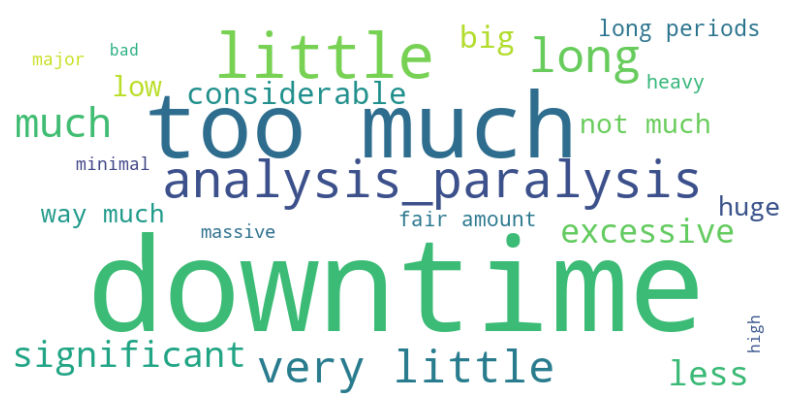

In [476]:
get_cloud(Sn_down)

In [477]:
dwt_low=Final_down.sort_values(['Mean_Stars'])[:5]
dwt_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
0,downtime,massive,5.0,0.0000,0.1078,0.7611,0.1311,3.833
1,downtime,excessive,12.0,-0.3125,0.0648,0.8679,0.0673,5.215
14,downtime,huge,6.0,-0.1250,0.0177,0.7174,0.2648,5.392
4,downtime,big,9.0,0.0809,0.1257,0.7751,0.0992,5.440
19,analysis_paralysis,heavy,5.0,-0.0542,0.1675,0.7085,0.1238,5.462


In [479]:
dwt_top=Final_down.sort_values(['Mean_Stars'],ascending=False)[:5]
dwt_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
10,downtime,low,8.0,-0.2500,0.2504,0.6680,0.0817,8.098
15,downtime,very little,30.0,0.0281,0.0206,0.8387,0.1407,8.035
18,downtime,little,47.0,-0.2250,0.0376,0.8127,0.1497,6.916
23,analysis_paralysis,little,13.0,-0.2250,0.0391,0.8418,0.1191,6.783
20,analysis_paralysis,major,5.0,0.0481,0.0749,0.8425,0.0825,6.727


### Downtime and different categories

In [481]:
counter_res = Counter(Sn[Sn['noun'] == 'downtime']['category'].values)

# Sort the result by count in descending order
sorted(counter_res.items(), key=lambda x: x[1], reverse=True)[:5]

[('Wargame', 83),
 ('Economic', 75),
 ('Fantasy', 55),
 ('Card Game', 48),
 ('Exploration', 43)]

In [645]:

War_stars=list(Sn_down[Sn_down['category']=='Wargame'].stars.values)
Economic_stars=list(Sn_down[Sn_down['category']=='Economic'].stars.values)
Fantasy_stars=list(Sn_down[Sn_down['category']=='Fantasy'].stars.values)
Card_stars=list(Sn_down[Sn_down['category']=='Card Game'].stars.values)
Exploration_stars=list(Sn_down[Sn_down['category']=='Exploration'].stars.values)



h_statistic, p_value = stats.kruskal(War_stars,Economic_stars,Fantasy_stars,Card_stars,Exploration_stars)

print(f" The Kruskal-Wallis H Test:  'h_statistic': {round(h_statistic,2)}  'p_value': {p_value}")
print('   ')

print(f"The mean confidence interval for War Games is: {mean_int(War_stars)[1]}-{mean_int(War_stars)[2]}")
print(f"The mean confidence interval for Economic Games is: {mean_int(Economic_stars)[1]}-{mean_int(Economic_stars)[2]}")
print(f"The mean confidence interval Fantasy Games is: {mean_int(Fantasy_stars)[1]}-{mean_int(Fantasy_stars)[2]}")
print(f"The mean confidence interval for Card Games is: {mean_int(Card_stars)[1]}-{mean_int(Card_stars)[2]}")
print(f"The mean confidence interval Exploration Games is: {mean_int(Exploration_stars)[1]}-{mean_int(Exploration_stars)[2]}")



 The Kruskal-Wallis H Test:  'h_statistic': 1.93  'p_value': 0.7482062420813436
   
The mean confidence interval for War Games is: 5.871-6.729
The mean confidence interval for Economic Games is: 5.76-6.64
The mean confidence interval Fantasy Games is: 5.513-6.487
The mean confidence interval for Card Games is: 5.536-6.464
The mean confidence interval Exploration Games is: 5.537-6.663


In [483]:

ASPECTS.append({
    'OBJECT': 'DOWNTIME',
    'Similar': down_similarity,
    'Synset_pol': round(np.average(Final_down.Synset_pol.values,weights=Final_down.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_down.Sentence_neg.values,weights=Final_down.Count.values),2),
        'neu':round(np.average(Final_down.Sentence_neu.values,weights=Final_down.Count.values),2),
        'pos':round(np.average(Final_down.Sentence_pos.values,weights=Final_down.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_down.Mean_Stars.values,weights=Final_down.Count.values),2)
})


[{'OBJECT': 'LUCK',
  'Similar': ['luck_factor', 'chaos', 'randomness'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.08, 'neu': 0.65, 'pos': 0.27},
  'Mean_Stars': 5.9},
 {'OBJECT': 'INTERACTION',
  'Similar': ['interaction', 'interactivity', 'influence'],
  'Synset_pol': -0.05,
  'Sentence_pol': {'neg': 0.07, 'neu': 0.77, 'pos': 0.16},
  'Mean_Stars': 6.22},
 {'OBJECT': 'BOOKKEEPING',
  'Similar': ['bookkeeping', 'paperwork', 'scorekeeping', 'accounting'],
  'Synset_pol': -0.02,
  'Sentence_pol': {'neg': 0.05, 'neu': 0.83, 'pos': 0.12},
  'Mean_Stars': 5.48},
 {'OBJECT': 'DOWNTIME',
  'Similar': ['downtime', 'analysis_paralysis'],
  'Synset_pol': -0.05,
  'Sentence_pol': {'neg': 0.06, 'neu': 0.83, 'pos': 0.12},
  'Mean_Stars': 6.22}]

# N°5:  Complex vs. Complicated

In [484]:
R0.wv.most_similar(positive=['complex'])

[('complicated', 0.9290238618850708),
 ('convoluted', 0.7523529529571533),
 ('detailed', 0.7260088324546814),
 ('simplistic', 0.7245482206344604),
 ('fiddly', 0.7067105770111084),
 ('sophisticated', 0.7001253962516785),
 ('cumbersome', 0.6770558953285217),
 ('granular', 0.6731828451156616),
 ('demanding', 0.6724082827568054),
 ('restrictive', 0.6588699221611023)]

In [485]:
R0.wv.most_similar(positive=['complicated'])

[('complex', 0.9290238618850708),
 ('convoluted', 0.8194864392280579),
 ('fiddly', 0.7669544816017151),
 ('finicky', 0.7150262594223022),
 ('simplistic', 0.7133936882019043),
 ('cumbersome', 0.7106465697288513),
 ('fussy', 0.6892792582511902),
 ('restrictive', 0.6736506819725037),
 ('daunting', 0.6672991514205933),
 ('dense', 0.6617228984832764)]

In [486]:
cvc_similarity_nouns=['complexity','complication']
cvc_similarity_adjs=['complex','complicated']

#### Most important factor a for positive or negative reviews

In [487]:
E_cvc= get_born(E,cvc_similarity_nouns)
E_cvc.sort_values('Positive', ascending=False).head(3)

,Positive,Neutral,Negative
"(complexity, right level)",0.006537,0.0,0.0
"(complexity, right)",0.006104,0.0,0.0
"(complexity, right amount)",0.006015,0.0,0.0


In [488]:
E_cvc.sort_values('Negative', ascending=False).head(3)

,Positive,Neutral,Negative
"(complication, needless)",0.000000,0.000000,0.007544
"(complexity, unnecessary)",0.003133,0.000862,0.005721
"(complexity, extra)",0.000807,0.002363,0.003048


 ##  Summary Dataframe 

In [489]:
Sn_cvc= get_df(Sn,cvc_similarity_nouns,cvc_similarity_adjs,[])

Final_cvc_nouns=get_info(cvc_similarity_nouns,[],Sn_cvc,E)
Final_cvc_adjs=get_info([],cvc_similarity_adjs,Sn_cvc,E)


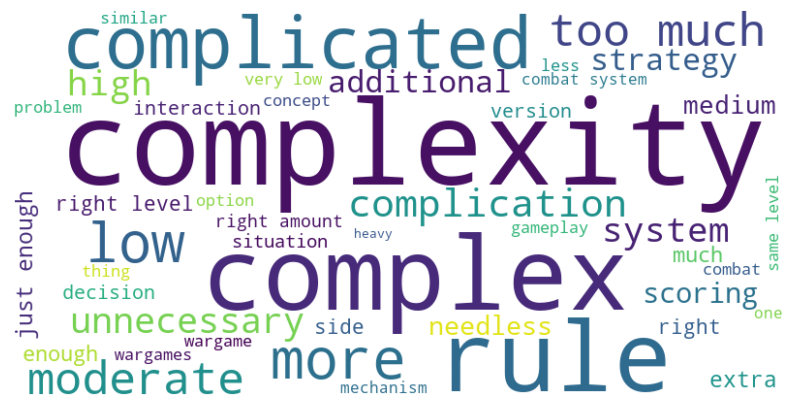

In [490]:
get_cloud(Sn_cvc)

In [491]:
cvc_low=Final_cvc_nouns.sort_values('Mean_Stars')[:5]
cvc_low

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
25,complication,needless,5.0,-0.0714,0.0856,0.7669,0.1475,4.632
1,complexity,unnecessary,24.0,0.0000,0.0429,0.8711,0.0861,5.166
5,complexity,too much,44.0,0.0312,0.0491,0.8198,0.1311,5.489
20,complexity,needless,15.0,-0.0714,0.0432,0.8446,0.1121,5.638
2,complexity,extra,14.0,0.0179,0.0513,0.8011,0.1476,6.029


In [493]:
cvc_top=Final_cvc_nouns.sort_values('Mean_Stars',ascending=False)[:5]
cvc_top

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
8,complexity,right,13.0,0.1736,0.0352,0.8130,0.1519,8.491
19,complexity,just enough,13.0,0.1979,0.0102,0.8540,0.1358,7.917
14,complexity,right amount,10.0,0.0600,0.0000,0.8690,0.1310,7.880
23,complication,additional,6.0,0.0000,0.0000,0.8906,0.1094,7.667
15,complexity,right level,11.0,0.0868,0.0288,0.7972,0.1739,7.483


###  What do complexity and complicatedness refers to?

The code will show those nouns that are associated with to 'complex' but not to 'complicated' 

In [495]:
complex_adjs=Final_cvc_adjs[Final_cvc_adjs['Adj']=='complex'][['Object','Count']].values
complicated_adjs=Final_cvc_adjs[Final_cvc_adjs['Adj']=='complicated'][['Object','Count']].values

complex_use=[]
complicated_use=[]
for noun,count in complex_adjs:
    complex_use.append(noun)
for noun,count in complicated_adjs:
    complicated_use.append(noun)
        
complex_diff= list(set(complex_use) -  set(complicated_use))

difference=Final_cvc_adjs[np.isin(Final_cvc_adjs['Object'],complex_diff)][['Object','Count']].sort_values('Count',ascending=False)[:10]
difference

,Object,Count
11,strategy,29.0
7,side,12.0
13,interaction,12.0
1,decision,10.0
5,gameplay,10.0
6,wargame,10.0
2,situation,9.0
3,combat,7.0
0,problem,6.0
12,mechanism,6.0


In [497]:
Final_cvc_adjs[Final_cvc_adjs['Adj']=='complicated'].sort_values('Count',ascending=False)[:10]

,Object,Adj,Count,Synset_pol,Sentence_neg,Sentence_neu,Sentence_pos,Mean_Stars
21,rule,complicated,122.0,-0.25,0.0628,0.7953,0.1418,6.207
20,scoring,complicated,19.0,-0.25,0.0931,0.8108,0.0961,6.119
22,version,complicated,10.0,-0.25,0.1352,0.8113,0.0535,5.734
17,system,complicated,6.0,-0.25,0.0702,0.8111,0.1187,7.190
18,thing,complicated,6.0,-0.25,0.0935,0.7630,0.1433,5.650
19,one,complicated,5.0,-0.25,0.0000,0.9339,0.0661,5.469


In [498]:
# Some sentences involves complex and complicated together

cvc_sents=list(set(Sn.sentence.values))

for sent in cvc_sents:
    if ('complex' in sent and  'complicated' in sent):
        print(sent)
        print('_____________')
        print('')

Let's make the most complicated game on the planet even more complex!!!
_____________

It's more complicated than the pure fillers, but not as complex as most others.  
_____________

Accomplishes what more complex/complicated games of similar genre attempt to do with a fraction of the rules overhead.  
_____________

A bit on the complicated side with not enough payoff for the complexity.
_____________

Lots of little plastic bits and complicated special cases in the rules that seemed to make things more complex without adding tactical depth.  
_____________

Hitler's War is in truth not *that* complicated, but it's enough stuff scattered all over the place to cause problems; it lacks the solid "central mechanism" of an Axis & Allies: Europe or EastFront, and as such feels complex because it's more of an aggregate of lots of little stuff, none of which is very important.
_____________

Land, sea and air combat with a focus on logistics, played across two map scales, and with a sequenc

In [646]:

ASPECTS.append({
    'OBJECT': 'COMPLEXITY & COMPLICATEDNESS',
    'Similar': cvc_similarity_nouns,
    'Synset_pol': round(np.average(Final_cvc_nouns.Synset_pol.values,weights=Final_cvc_nouns.Count.values),2),
    'Sentence_pol': {
        'neg':round(np.average(Final_cvc_nouns.Sentence_neg.values,weights=Final_cvc_nouns.Count.values),2),
        'neu':round(np.average(Final_cvc_nouns.Sentence_neu.values,weights=Final_cvc_nouns.Count.values),2),
        'pos':round(np.average(Final_cvc_nouns.Sentence_pos.values,weights=Final_cvc_nouns.Count.values),2),
                         },
    'Mean_Stars': round(np.average(Final_cvc_nouns.Mean_Stars.values,weights=Final_cvc_nouns.Count.values),2)
})


##  Study complexity behaviour along with other features of a board game

Since BGG provides the a complexity score for each game, we can exploit this measure and make a combine study along with other statistics that BGG provides.

#### Create a statistics dataframe

In [647]:
complex_data=[]
for title in titles:
    for cat in BGG[title]['categories']:
        complex_data.append({
                            'Name': BGG[title]['name'], 
                            'Category': cat,
                            'Rating': BGG[title]['rating'],
                            'Complexity': BGG[title]['complexity'], 
                            'Min_Players':BGG[title]['min_players'], 
                            'Max_Players': BGG[title]['max_players'], 
                            'Min_Playtime': BGG[title]['min_lenght'], 
                            'Max_Playtime': BGG[title]['max_lenght'],
                            'Age':BGG[title]['age']
        })
comp_df = pd.DataFrame(complex_data)

comp_df.head()

    
    

,Name,Category,Rating,Complexity,Min_Players,Max_Players,Min_Playtime,Max_Playtime,Age
0,Die Macher,Economic,7.59346,4.3105,3.0,5.0,240.0,240.0,14.0
1,Die Macher,Negotiation,7.59346,4.3105,3.0,5.0,240.0,240.0,14.0
2,Die Macher,Political,7.59346,4.3105,3.0,5.0,240.0,240.0,14.0
3,Dragonmaster,Card Game,6.65084,1.9643,3.0,4.0,30.0,30.0,12.0
4,Dragonmaster,Fantasy,6.65084,1.9643,3.0,4.0,30.0,30.0,12.0


In [501]:
# We are filtering categories to retain only the most important ones

filter_cat=['Wargame','Card Game',"Children's Game",'Abstract Strategy','Fantasy','Dice','Party Game'
             ,'Science Fiction','Miniatures','Economic','Fighting','Trivia','Educational'
             ,'Action / Dexterity','Sports','Humor','Racing','Memory','Negotiation','Adventure'
             ,'Medieval','Word Game','Bluffing','Nautica','Deduction','Exploration'
             ,'Political','Book','Horror','Animals']

comp_df=comp_df[np.isin(comp_df['Category'],filter_cat)]

In [502]:
### Clean outliers
comp_df=comp_df[~np.isin(comp_df['Rating'],[0])]
comp_df=comp_df[~np.isin(comp_df['Complexity'],[0])]
comp_df=comp_df[np.isin(comp_df['Age'],range(4,25))]
comp_df=comp_df[np.isin(comp_df['Min_Players'],range(1,25))]
comp_df=comp_df[np.isin(comp_df['Max_Players'],range(1,25))]
comp_df=comp_df[np.isin(comp_df['Min_Playtime'],range(1,720))]
comp_df=comp_df[np.isin(comp_df['Max_Playtime'],range(1,720))]

comp_df=comp_df[np.isin(comp_df['Category'],['Fantasy','Card Game','Wargame','Party Game'])]

### First test: Complexity-Category

We'll test if complexity the complexity differs between categories. 

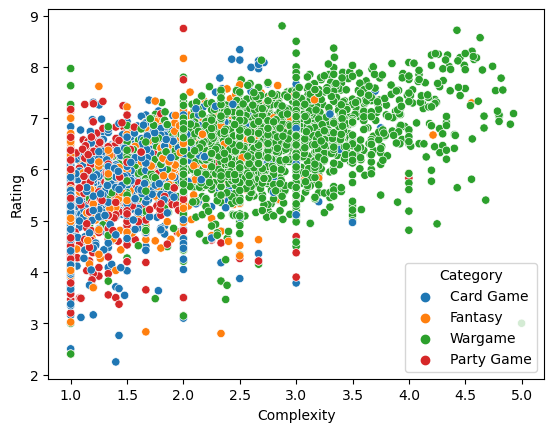

In [503]:
import seaborn as sns
sns.scatterplot(x="Complexity", y="Rating",hue='Category', data=comp_df);

In [598]:
Fantasy_stars=list(comp_df[comp_df['Category']=="Fantasy"].Complexity.values)
Party_stars=list(comp_df[comp_df['Category']=='Party Game'].Complexity.values)
War_stars=list(comp_df[comp_df['Category']=='Wargame'].Complexity.values)
Card_stars=list(comp_df[comp_df['Category']=='Card Game'].Complexity.values)

f_statistic, p_value = stats.f_oneway(Party_stars,Fantasy_stars,War_stars,Card_stars)

print(f" The Kruskal-Wallis H Test:  'f_statistic': {round(h_statistic,2)}  'p_value': {p_value}")
print('   ')

print(f"The mean confidence interval for Fantasy Games is: {mean_int(Fantasy_stars)[1]}-{mean_int(Fantasy_stars)[2]}")
print(f"The mean confidence interval Party Games is: {mean_int(Party_stars)[1]}-{mean_int(Party_stars)[2]}")
print(f"The mean confidence interval for War Games is: {mean_int(War_stars)[1]}-{mean_int(War_stars)[2]}")
print(f"The mean confidence interval for Card Games is: {mean_int(Card_stars)[1]}-{mean_int(Card_stars)[2]}")


 The Kruskal-Wallis H Test:  'f_statistic': 1.93  'p_value': 0.0
   
The mean confidence interval for Fantasy Games is: 1.942-2.058
The mean confidence interval Party Games is: 1.354-1.446
The mean confidence interval for War Games is: 2.767-2.833
The mean confidence interval for Card Games is: 1.568-1.632


#### Most complex and most accessible games

In [649]:
comp_cat=comp_df.groupby(['Category']).agg({'Complexity': ['mean']}).reset_index()
comp_cat.sort_values([('Complexity','mean')],ascending=False).head(5)

,Category,Complexity
,,mean
82,World War II,2.899364
57,Pike and Shot,2.807129
18,Civilization,2.755749
17,Civil War,2.735898
60,Post-Napoleonic,2.668048


In [650]:
comp_cat.sort_values([('Complexity','mean')],ascending=True).head(5)

,Category,Complexity
,,mean
29,Fan Expansion,0.583333
15,Children's Game,0.935672
1,Action / Dexterity,0.988440
42,Medical,1.012212
24,Educational,1.019050


## Second test:  Correlation study between complexity and other statistics

In [507]:
cor_matrix = comp_df[['Rating','Complexity','Min_Players','Max_Players','Min_Playtime','Max_Playtime','Age']].corr()
round(cor_matrix,2)

,Rating,Complexity,Min_Players,Max_Players,Min_Playtime,Max_Playtime,Age
Rating,1.00,0.56,-0.10,-0.20,0.38,0.38,0.31
Complexity,0.56,1.00,-0.24,-0.31,0.64,0.64,0.49
Min_Players,-0.10,-0.24,1.00,0.31,-0.15,-0.15,0.03
Max_Players,-0.20,-0.31,0.31,1.00,-0.24,-0.24,-0.15
Min_Playtime,0.38,0.64,-0.15,-0.24,1.00,1.00,0.43
Max_Playtime,0.38,0.64,-0.15,-0.24,1.00,1.00,0.43
Age,0.31,0.49,0.03,-0.15,0.43,0.43,1.00


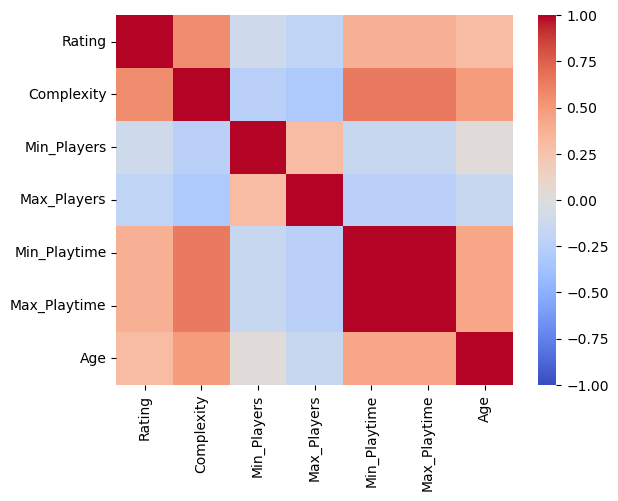

In [605]:
sns.heatmap(cor_matrix,cmap='coolwarm',vmin=-1,vmax=1)
plt.savefig('Latex/Complexity_stats.png',bbox_inches='tight')

# N°6: Bash the leader

In [509]:
R0.wv.most_similar(positive=['bash_the_leader'])

[('bash_the_leadering', 0.8885086178779602),
 ('runaway', 0.7207047343254089),
 ('bash_the_leadered', 0.6686334013938904),
 ('hornet', 0.5958297252655029),
 ('perceived', 0.5884613990783691),
 ('thunderbolt', 0.5672723650932312),
 ('analysis_paralysisache', 0.5428826212882996),
 ('squad', 0.5113956928253174),
 ('whack', 0.5097439289093018),
 ('rein', 0.5000892281532288)]

In [510]:
bash_similarity=['bash_the_leader']

## Summary Dataframe

This time, since all the pairs about bashing do not overcome the frequency threshold of 5, the dataframe has been constructed using single comments

In [616]:
Sn_bash=S[np.isin(S['noun'],bash_similarity)]

Sn_bash=Sn_bash.groupby(['doc','noun','adj']).first().reset_index()[['doc','category','noun','adj','stars','sentence']]

sentiment_scores = Sn_bash['sentence'].apply(lambda sent: sid.polarity_scores(sent))

Sn_bash[['Sent_neg', 'Sent_neu', 'Sent_pos']] = sentiment_scores.apply(
    lambda x: pd.Series([x['neg'], x['neu'], x['pos']]))

Sn_bash['Synset_pol'] = Sn_bash['adj'].apply(lambda adj: np.mean([sentiwn_score(word) for word in adj.split()]))

bash=Sn_bash[['category','noun','adj','Synset_pol','Sent_neg','Sent_neu','Sent_pos','stars']].sort_values('stars',ascending=False)
bash

,category,noun,adj,Synset_pol,Sent_neg,Sent_neu,Sent_pos,stars
9,Age of Reason,bash_the_leader,bad,-0.595588,0.260,0.563,0.177,9.0
2,Card Game,bash_the_leader,overwhelming,-0.104167,0.000,1.000,0.000,6.5
3,Card Game,bash_the_leader,fun game,-0.051339,0.000,0.784,0.216,6.0
5,Card Game,bash_the_leader,strong,0.075000,0.000,0.696,0.304,6.0
7,Card Game,bash_the_leader,huge,-0.125000,0.218,0.647,0.135,6.0
1,Card Game,bash_the_leader,too much,0.031250,0.000,1.000,0.000,5.0
6,Card Game,bash_the_leader,too much,0.031250,0.000,1.000,0.000,5.0
4,Card Game,bash_the_leader,too much,0.031250,0.000,1.000,0.000,4.0
8,Card Game,bash_the_leader,severe,-0.270833,0.418,0.448,0.134,4.0
10,Pirates,bash_the_leader,mindless,-0.225000,0.326,0.674,0.000,4.0


In [651]:

ASPECTS.append({
    'OBJECT': 'BASH THE LEADER',
    'Similar': bash_similarity,
    'Synset_pol': round(Sn_bash.Synset_pol.values.mean(),2),
    'Sentence_pol': {
        'neg':round(Sn_bash.Sent_neg.values.mean(),2),
        'neu':round(Sn_bash.Sent_neu.values.mean(),2),
        'pos':round(Sn_bash.Sent_pos.values.mean(),2),
                },
    'Mean_Stars': round(Sn_bash.stars.values.mean(),2)
})


# FINAL SUMMARY FOR BOARD GAME ASPECTS 

We are creating a table with the summarized statistics that can be used to draw general information about the sentiment of aspects.

In [654]:
Summary= pd.DataFrame(ASPECTS)
Summary=Summary[['OBJECT','Similar','Synset_pol','Mean_Stars']]

In [655]:
neg,neu,pos,blob=[],[],[],[]
for i,aspect in enumerate(ASPECTS):
    neg.append(aspect['Sentence_pol']['neg'])
    neu.append(aspect['Sentence_pol']['neu'])
    pos.append(aspect['Sentence_pol']['pos'])
    
Summary['Sent_neg'],Summary['Sent_neu'],Summary['Sent_pos']= neg,neu,pos
Summary

,OBJECT,Similar,Synset_pol,Mean_Stars,Sent_neg,Sent_neu,Sent_pos
0,LUCK,"[luck_factor, chaos, randomness]",-0.02,5.90,0.08,0.65,0.27
1,INTERACTION,"[interaction, interactivity, influence]",-0.05,6.22,0.07,0.77,0.16
2,BOOKKEEPING,"[bookkeeping, paperwork, scorekeeping, account...",-0.02,5.48,0.05,0.83,0.12
3,DOWNTIME,"[downtime, analysis_paralysis]",-0.05,6.22,0.06,0.83,0.12
4,COMPLEXITY & COMPLICATEDNESS,"[complexity, complication]",-0.04,6.64,0.07,0.81,0.12
5,BASH THE LEADER,[bash_the_leader],-0.11,5.32,0.11,0.77,0.12
6,COMPLEXITY & COMPLICATEDNESS,"[complexity, complication]",-0.04,6.64,0.07,0.81,0.12
7,BASH THE LEADER,[bash_the_leader],-0.11,5.32,0.11,0.77,0.12
